# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [2]:
! pip install bigartm
import artm

     |████████████████████████████████| 1.9MB 2.6MB/s 


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [8]:
from google.colab import files
uploaded = files.upload()
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=250)

Saving lectures.txt to lectures.txt


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [0]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [0]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [18]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print (topic_name + ': '),
    for word in tokens[topic_name]:    
        print (word)
    print()

sbj0: 


(None,)

власть
александр
римский
церковь
средневековый
император
русь
доходить
святой
папа
вера
рассказ
князь
славянский
павел

sbj1: 


(None,)

земля
планета
вокруг
образовываться
газ
атмосфера
белый
солнце
диск
солнечный
давление
зона
металл
карлик
двойной

sbj2: 


(None,)

система
атом
движение
двигаться
трудность
переход
частота
точность
искусственный
интеллект
час
парадокс
спина
стандарт
участник

sbj3: 


(None,)

культура
понятие
культурный
восприятие
сознание
воспринимать
личность
ощущение
окружающий
глобальный
чужой
климат
этика
трансформация
индивид

sbj4: 


(None,)

право
литература
литературный
искусство
требование
критерий
юридический
писатель
договор
должник
собственность
обязательство
защита
владение
сосед

sbj5: 


(None,)

структура
материал
свойство
молекула
применение
электронный
углерод
поверхность
полимер
твердый
предсказание
кристалл
трехмерный
алмаз
углеродный

sbj6: 


(None,)

тема
автор
фильм
герой
театр
посвящать
кино
жанр
фрагмент
екатерина
академия
кинематограф
снимать
анекдот
ученик

sbj7: 


(None,)

смерть
правитель
идеология
ритуал
террор
служба
государь
обряд
разум
символический
насилие
конвент
лидер
моральный
субъективный

sbj8: 


(None,)

химический
реакция
соединение
химия
продукт
лекарство
синтез
органический
получение
природный
концентрация
натрий
воздух
антибиотик
химик

sbj9: 


(None,)

теория
частица
модель
энергия
взаимодействие
пространство
три
поле
описывать
квантовый
эксперимент
физика
эффект
магнитный
электрон

sbj10: 


(None,)

русский
россия
война
советский
российский
мировой
немецкий
германия
государственный
против
реформа
военный
петр
союз
гражданский

sbj11: 


(None,)

ребенок
возраст
конфликт
кровь
взрослый
мать
сон
родитель
показатель
катастрофа
старение
опасный
травма
негативный
обезьяна

sbj12: 


(None,)

вода
растение
ткань
орган
иммунный
сердце
рак
озеро
опухоль
популяция
кислота
нейронный
мышца
птица
уменьшаться

sbj13: 


(None,)

государство
древний
народ
территория
христианский
империя
восток
население
письменность
сохраняться
северный
регион
цивилизация
китай
памятник

sbj14: 


(None,)

звезда
объект
галактика
масса
вещество
источник
свет
черный
волна
скорость
наблюдать
вселенная
дыра
физико-математический
излучение

sbj15: 


(None,)

задача
информация
данные
память
внимание
анализ
компьютер
психология
мышление
способность
оценка
объем
деньги
психологический
ваш

sbj16: 


(None,)

америка
раса
африка
структурный
остров
южный
станислав
волос
нос
узкий
лес
индия
сенсор
монголоид
дробышевский

sbj17: 


(None,)

политический
философия
философский
философ
партия
мысль
правовой
штат
свободный
юрист
чтение
профессиональный
суд
рабочий
режим

sbj18: 


(None,)

слово
текст
значение
речь
лицо
словарь
категория
контекст
предложение
конструкция
вроде
корпус
глагол
лингвистика
записывать

sbj19: 


(None,)

революция
французский
свобода
национальный
франция
международный
роман
локальный
аргумент
костюм
сцена
нация
житель
творчество
актер

sbj20: 


(None,)

город
технология
сеть
устройство
робот
городской
интернет
управление
дом
компания
пользователь
музей
технологический
контроль
библиотека

sbj21: 


(None,)

болезнь
заболевание
женщина
пациент
лечение
медицина
операция
врач
боль
препарат
нарушение
медицинский
мужчина
больной
диагностика

sbj22: 


(None,)

форма
знание
социология
описание
перевод
дисциплина
социологический
обучение
познание
коммуникация
виктор
переводить
социолог
анализировать
совокупность

sbj23: 


(None,)

схема
матрица
микроорганизм
эмоция
алгоритм
чистый
вычислительный
эмоциональный
глубина
базовый
микроб
программный
обеспечение
фольклор
прогноз

sbj24: 


(None,)

исторический
представление
бог
миф
царь
греческий
письмо
андрей
море
религиозный
по-видимому
сюжет
религия
душа
сын

sbj25: 


(None,)

язык
программа
английский
лингвист
языковой
звук
гласный
согласный
лингвистический
говор
дерево
диалект
мягкий
древнерусский
произносить

sbj26: 


(None,)

решение
поведение
политика
экономический
экономика
выбор
прошлое
ценность
ресурс
идентичность
кризис
принятие
сталин
коллективный
стратегия

sbj27: 


(None,)

клетка
мозг
организм
ген
днк
белок
биологический
животное
генетический
живой
нейрон
способный
последовательность
молекулярный
сигнал

sbj28: 


(None,)

температура
университет
профессор
сверхпроводимость
критический
студент
сверхпроводник
факультет
исследовательский
сверхпроводящий
электроника
железо
команда
сопротивление
заимствование

bcg: 


(None,)

KeyError: ignored

In [0]:
# Ваш код
authors = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print topic_name + ': ',
    for author in authors[topic_name]:    
        print author,
    print

sbj0:  Александр_Марей Фёдор_Успенский Татьяна_Бобровникова Павел_Уваров Алексей_Юдин Игорь_Данилевский Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Григорий_Бондаренко Раиса_Кирсанова Екатерина_Болтунова Ольга_Тогоева
sbj1:  Сергей_Попов Кирилл_Еськов Дмитрий_Вибе Валерий_Сулейманов Дмитрий_Титов Зоригто_Намсараев Сергей_Наугольных Александр_Марков Елизавета_Ривкина Наталья_Новикова Роман_Рафиков Александр_Слободкин Сергей_Писарев Дмитрий_Лось Юлия_Краус
sbj2:  Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Эмиль_Ахмедов Виталий_Пальчиков Михаил_Фейгельман Даниэль_Сельва Антон_Суворов Василий_Климов Алексей_Желтиков Юджин_Ползик Илья_Щуров Владимир_Редько Георгий_Шляпников
sbj3:  Пётр_Турчин Алексей_Руткевич Владимир_Миронов Сергей_Арутюнов Татьяна_Смоктунович Андрей_Лосев Константин_Анохин Кирилл_Разлогов Дмитрий_Иванов Павел_Степанцов Александр_Кислов Фёдор_Гиренок Павел_Умрюхин Светлана_Кузнецова Андрей_Лукашов
sbj4:  Дмитрий_Дож

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [20]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + [u"Фоновая тема"]

print(sbj_topic_labels)

['власть', 'земля', 'система', 'культура', 'право', 'структура', 'тема', 'смерть', 'химический', 'теория', 'русский', 'ребенок', 'вода', 'государство', 'звезда', 'задача', 'америка', 'политический', 'слово', 'революция', 'город', 'болезнь', 'форма', 'схема', 'исторический', 'язык', 'решение', 'клетка', 'температура']


##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [21]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 1728)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [22]:
# Ваш код
theta.iloc[:,:100]

,http://postnauka.ru/video/49203,http://postnauka.ru/video/49206,http://postnauka.ru/video/49257,http://postnauka.ru/video/49258,http://postnauka.ru/video/49259,http://postnauka.ru/video/49261,http://postnauka.ru/video/49262,http://postnauka.ru/video/49284,http://postnauka.ru/video/49431,http://postnauka.ru/video/49432,http://postnauka.ru/video/49435,http://postnauka.ru/video/49437,http://postnauka.ru/video/49439,http://postnauka.ru/video/49441,http://postnauka.ru/video/49443,http://postnauka.ru/video/49445,http://postnauka.ru/video/49447,http://postnauka.ru/video/49448,http://postnauka.ru/video/49451,http://postnauka.ru/video/49453,http://postnauka.ru/video/49455,http://postnauka.ru/video/49457,http://postnauka.ru/video/49459,http://postnauka.ru/video/49461,http://postnauka.ru/video/49595,http://postnauka.ru/video/49597,http://postnauka.ru/video/49848,http://postnauka.ru/video/49850,http://postnauka.ru/video/49851,http://postnauka.ru/video/49854,http://postnauka.ru/video/49856,http://postnauka.ru/video/49858,http://postnauka.ru/video/49863,http://postnauka.ru/video/49866,http://postnauka.ru/video/50060,http://postnauka.ru/video/50063,http://postnauka.ru/video/50066,http://postnauka.ru/video/50068,http://postnauka.ru/video/50071,http://postnauka.ru/video/50085,...,http://postnauka.ru/video/50704,http://postnauka.ru/video/50706,http://postnauka.ru/video/50786,http://postnauka.ru/video/50792,http://postnauka.ru/video/50793,http://postnauka.ru/video/50797,http://postnauka.ru/video/50798,http://postnauka.ru/video/50800,http://postnauka.ru/video/50886,http://postnauka.ru/video/51169,http://postnauka.ru/video/51171,http://postnauka.ru/video/51174,http://postnauka.ru/video/51178,http://postnauka.ru/video/51180,http://postnauka.ru/video/51184,http://postnauka.ru/video/51186,http://postnauka.ru/video/51188,http://postnauka.ru/video/51194,http://postnauka.ru/video/51196,http://postnauka.ru/video/51201,http://postnauka.ru/video/51203,http://postnauka.ru/video/51205,http://postnauka.ru/video/51288,http://postnauka.ru/video/51331,http://postnauka.ru/video/51348,http://postnauka.ru/video/51350,http://postnauka.ru/video/51353,http://postnauka.ru/video/51357,http://postnauka.ru/video/51364,http://postnauka.ru/video/51365,http://postnauka.ru/video/51366,http://postnauka.ru/video/51367,http://postnauka.ru/video/51371,http://postnauka.ru/video/51374,http://postnauka.ru/video/51376,http://postnauka.ru/video/51378,http://postnauka.ru/video/51380,http://postnauka.ru/video/51382,http://postnauka.ru/video/51384,http://postnauka.ru/video/51486
sbj0,0.038948,0.004988,0.000000,4.618936e-03,0.011205,0.000000e+00,2.885900e-10,0.195970,0.000000,0.003415,1.010101e-02,0.003279,0.002545,0.011142,0.007434,0.018382,0.000000,0.022384,0.006742,1.061359e-01,0.023256,0.102731,0.014354,0.006452,0.506244,0.473639,0.000000,0.000000,0.011691,4.098359e-03,5.128204e-03,9.677423e-03,0.004525,0.013858,6.601450e-02,0.061939,0.062201,0.031747,2.102105e-02,0.008287,...,0.018357,0.014085,0.000000,0.015060,0.020202,0.000000,0.081633,0.025496,0.000000,0.008893,0.017364,0.002959,1.567398e-02,0.020231,0.000000,0.012887,0.036423,0.010256,0.007018,0.022669,0.002505,0.000000,0.002679,0.051047,2.996736e-03,0.000000,0.000000,5.967188e-02,3.472213e-03,0.011050,0.002375,1.569721e-01,0.004149,0.036539,0.005602,0.002933,0.103627,0.007174,0.012658,0.023077
sbj1,0.008097,0.012469,0.003953,0.000000e+00,0.047794,6.355417e-01,6.538313e-02,0.002155,0.017065,0.060924,1.248780e-13,0.121379,0.030534,0.002786,0.099265,0.007353,0.055435,0.002747,0.256179,2.109706e-03,0.000000,0.005021,0.012350,0.009677,0.001931,0.002844,0.000000,0.015130,0.104113,0.000000e+00,2.846211e-01,9.750438e-03,0.022624,0.066204,0.000000e+00,0.000000,0.004808,0.002975,6.006016e-03,0.002762,...,0.003058,0.004695,0.002865,0.027108,0.002537,0.060254,0.007653,0.008604,0.005698,0.028103,0.008157,0.024216,6.269594e-03,0.005551,0.009423,0.002577,0.005745,0.046257,0.242009,0.010704,0.014388,0.027211,0.009192,0.008565,3.257516e-12,0.00

C:\ProgramData\Anaconda3\envs\python2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


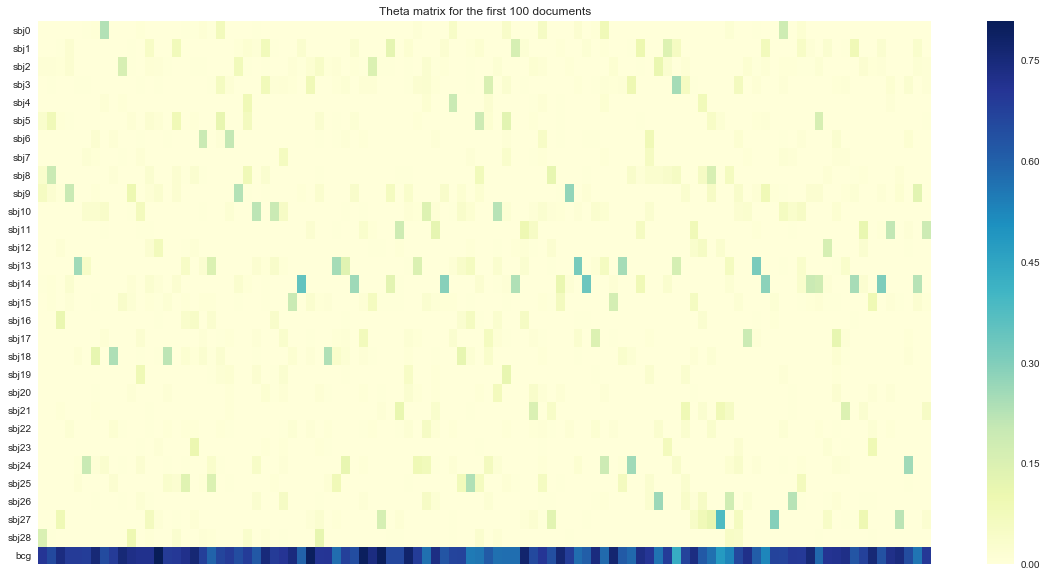

In [0]:
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [23]:
# Ваш код
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme

,prob
власть,0.037785
земля,0.032593
система,0.030129
культура,0.036662
право,0.024036
структура,0.032595
тема,0.021558
смерть,0.014235
химический,0.028359
теория,0.083564


In [0]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
клетка
частица
звезда
политический

Min 3 probabilities:
раса
смерть
температура


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Ваш ответ:
5 тем с max p(t):
Фоновая тема
клетка
частица
звезда
политический

3 темы с min p(t):
раса
смерть
температура

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

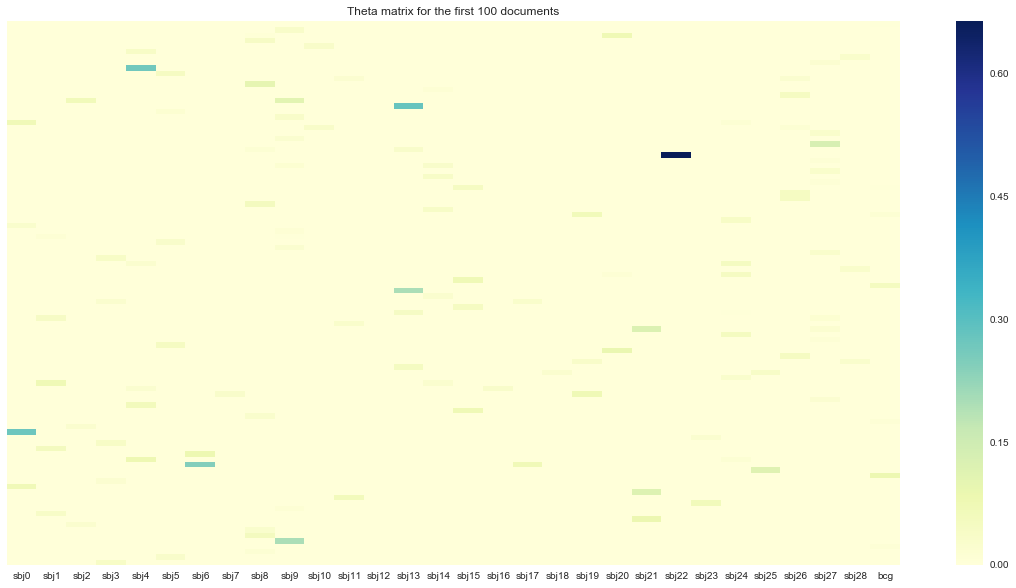

In [0]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [0]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,3.767525e-15,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.100183e-13,0.000000,0.000000e+00,0.004769
Сергей_Демокритов,0.000000,0.000000,5.080262e-16,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.488657e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Руслан_Смелянский,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.216063e-03,0.000000e+00,...,7.598587e-02,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Александр_Апт,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.259059e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Людмила_Новикова,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.456843e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Александр_Парфенов,0.000000,0.000000,0.000000e+00,0.000000e+00,0.041443,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Джеффри_Шнапп,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.390124e-09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.888579e-02,0.000000
Дмитрий_Чудаков,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.020226,0.000000e+00,0.000000
Дмитрий_Дождев,0.000000,0.000000,0.000000e+00,0.000000e+00,0.269379,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
Владимир_Шалаев,0.000000,0.000000,1.579593e-12,0.000000e+00,0.000000,4.802466e-02,0.000000e+00,0.000000e+00,1.163521e-15,6.123714e-15,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000


In [0]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i),
        print(phi_a.index[i])

184 Елена_Брызгалина
200 Андрей_Цатурян
229 Алина_Бодрова
342 Дмитрий_Лось


In [0]:
print(phi_a.iloc[184])

sbj0     0.000000e+00
sbj1     0.000000e+00
sbj2     1.054398e-01
sbj3     0.000000e+00
sbj4     0.000000e+00
sbj5     0.000000e+00
sbj6     0.000000e+00
sbj7     1.202001e-02
sbj8     0.000000e+00
sbj9     0.000000e+00
sbj10    0.000000e+00
sbj11    0.000000e+00
sbj12    0.000000e+00
sbj13    0.000000e+00
sbj14    0.000000e+00
sbj15    0.000000e+00
sbj16    0.000000e+00
sbj17    2.384968e-07
sbj18    0.000000e+00
sbj19    0.000000e+00
sbj20    0.000000e+00
sbj21    3.945983e-02
sbj22    0.000000e+00
sbj23    0.000000e+00
sbj24    0.000000e+00
sbj25    0.000000e+00
sbj26    0.000000e+00
sbj27    0.000000e+00
sbj28    0.000000e+00
bcg      0.000000e+00
Name: Елена_Брызгалина, dtype: float32


Ваш ответ:
авторы, значимые в не менее чем 3 темах:
184 Елена_Брызгалина
200 Андрей_Цатурян
229 Алина_Бодрова
342 Дмитрий_Лось

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [0]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [0]:
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [0]:
# Ваш код
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

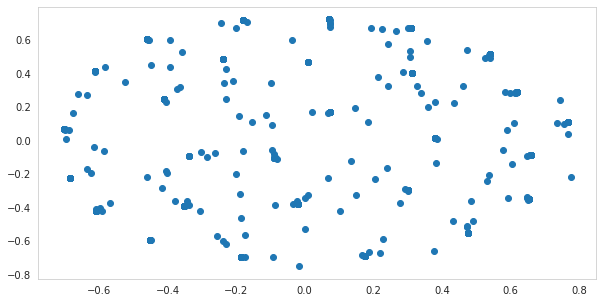

In [27]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

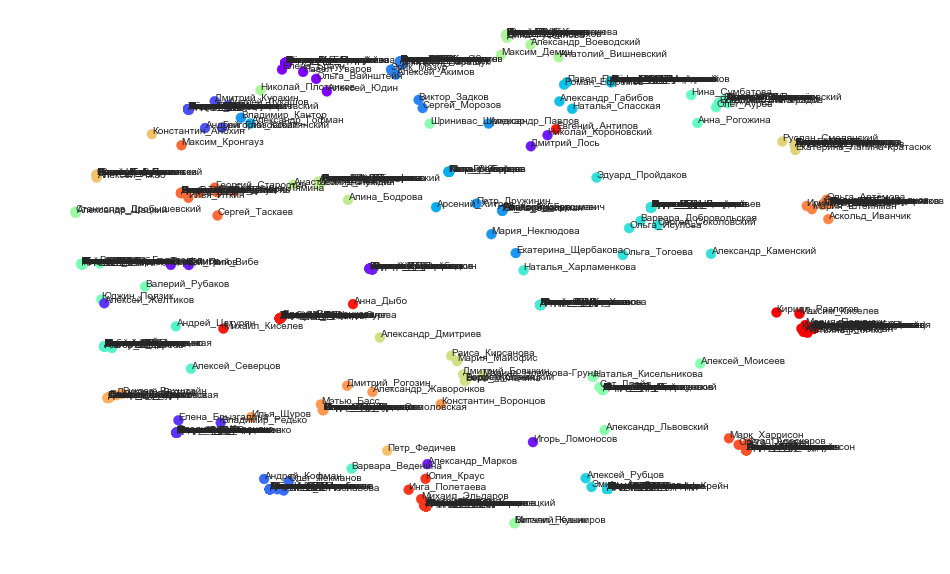

In [0]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [28]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1186, 1485,  191, ...,  639,  638,  615],
       [  88,    5, 1677, ...,  629,  628, 1453],
       [ 129,  130, 1121, ..., 1245,  410,  347],
       ...,
       [ 265, 1625, 1560, ...,  572, 1461,  596],
       [  44,  648,  508, ..., 1368, 1369,  521],
       [1161,  727,  589, ..., 1156, 1157,    0]])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [29]:
print "http://yandex.ru"   # получится кликабельная ссылка

SyntaxError: ignored

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [30]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [32]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j])
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

власть
александр
римский
церковь
средневековый
император
русь
доходить
святой
папа

http://postnauka.ru/video/24030
http://postnauka.ru/video/3348
http://postnauka.ru/video/5464
http://postnauka.ru/video/50668
http://postnauka.ru/video/50097
http://postnauka.ru/video/31677
http://postnauka.ru/video/53228
http://postnauka.ru/video/42993
http://postnauka.ru/video/5633
http://postnauka.ru/video/47449


земля
планета
вокруг
образовываться
газ
атмосфера
белый
солнце
диск
солнечный

http://postnauka.ru/video/51364
http://postnauka.ru/video/49261
http://postnauka.ru/video/37994
http://postnauka.ru/video/31695
http://postnauka.ru/video/46112
http://postnauka.ru/video/36249
http://postnauka.ru/video/5883
http://postnauka.ru/video/41338
http://postnauka.ru/video/32889
http://postnauka.ru/video/46113


система
атом
движение
двигаться
трудность
переход
частота
точность
искусственный
интеллект

http://postnauka.ru/video/52548
http://postnauka.ru/video/52553
http://postnauka.ru/video/21662
http://postnauka.ru/video/51174
http://postnauka.ru/video/56618
http://postnauka.ru/video/51382
http://postnauka.ru/video/53509
http://postnauka.ru/video/41348
http://postnauka.ru/video/37982
http://postnauka.ru/video/47457


культура
понятие
культурный
восприятие
сознание
воспринимать
личность
ощущение
окружающий
глобальный

http://postnauka.ru/video/12524
http://postnauka.ru/video/11034
http://postnauka.ru/video/12740
http://postnauka.ru/video/13180
http://postnauka.ru/video/6725
http://postnauka.ru/video/11626
http://postnauka.ru/video/20388
http://postnauka.ru/video/5891
http://postnauka.ru/video/36707
http://postnauka.ru/video/5180


право
литература
литературный
искусство
требование
критерий
юридический
писатель
договор
должник

http://postnauka.ru/video/17913
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/16822
http://postnauka.ru/video/31688
http://postnauka.ru/video/49455
http://postnauka.ru/video/39998
http://postnauka.ru/video/36715
http://postnauka.ru/video/31666
http://postnauka.ru/video/41100


структура
материал
свойство
молекула
применение
электронный
углерод
поверхность
полимер
твердый

http://postnauka.ru/video/13544
http://postnauka.ru/video/10379
http://postnauka.ru/video/41686
http://postnauka.ru/video/12375
http://postnauka.ru/video/31182
http://postnauka.ru/video/47818
http://postnauka.ru/video/46379
http://postnauka.ru/video/36490
http://postnauka.ru/video/18406
http://postnauka.ru/video/36657


тема
автор
фильм
герой
театр
посвящать
кино
жанр
фрагмент
екатерина

http://postnauka.ru/video/39723
http://postnauka.ru/video/47208
http://postnauka.ru/video/13541
http://postnauka.ru/video/10759
http://postnauka.ru/video/47202
http://postnauka.ru/video/19330
http://postnauka.ru/video/47204
http://postnauka.ru/video/38510
http://postnauka.ru/video/57127
http://postnauka.ru/video/57010


смерть
правитель
идеология
ритуал
террор
служба
государь
обряд
разум
символический

http://postnauka.ru/video/1893
http://postnauka.ru/video/32882
http://postnauka.ru/video/37992
http://postnauka.ru/video/1899
http://postnauka.ru/video/48480
http://postnauka.ru/video/50656
http://postnauka.ru/video/27967
http://postnauka.ru/video/42803
http://postnauka.ru/video/51331
http://postnauka.ru/video/40874


химический
реакция
соединение
химия
продукт
лекарство
синтез
органический
получение
природный

http://postnauka.ru/video/11646
http://postnauka.ru/video/51490
http://postnauka.ru/video/16171
http://postnauka.ru/video/2959
http://postnauka.ru/video/12971
http://postnauka.ru/video/47819
http://postnauka.ru/video/12259
http://postnauka.ru/video/32668
http://postnauka.ru/video/13700
http://postnauka.ru/video/19086


теория
частица
модель
энергия
взаимодействие
пространство
три
поле
описывать
квантовый

http://postnauka.ru/video/2945
http://postnauka.ru/video/18873
http://postnauka.ru/video/47952
http://postnauka.ru/video/47826
http://postnauka.ru/video/1894
http://postnauka.ru/video/33765
http://postnauka.ru/video/18870
http://postnauka.ru/video/53507
http://postnauka.ru/video/16827
http://postnauka.ru/video/51288


русский
россия
война
советский
российский
мировой
немецкий
германия
государственный
против

http://postnauka.ru/video/35041
http://postnauka.ru/video/31183
http://postnauka.ru/video/46939
http://postnauka.ru/video/42809
http://postnauka.ru/video/26667
http://postnauka.ru/video/51180
http://postnauka.ru/video/7283
http://postnauka.ru/video/25283
http://postnauka.ru/video/12148
http://postnauka.ru/video/42425


ребенок
возраст
конфликт
кровь
взрослый
мать
сон
родитель
показатель
катастрофа

http://postnauka.ru/video/59638
http://postnauka.ru/video/30678
http://postnauka.ru/video/17395
http://postnauka.ru/video/40266
http://postnauka.ru/video/60527
http://postnauka.ru/video/57657
http://postnauka.ru/video/22892
http://postnauka.ru/video/29103
http://postnauka.ru/video/30606
http://postnauka.ru/video/18613


вода
растение
ткань
орган
иммунный
сердце
рак
озеро
опухоль
популяция

http://postnauka.ru/video/16821
http://postnauka.ru/video/46562
http://postnauka.ru/video/51169
http://postnauka.ru/video/40277
http://postnauka.ru/video/51501
http://postnauka.ru/video/23172
http://postnauka.ru/video/30676
http://postnauka.ru/video/2958
http://postnauka.ru/video/59617
http://postnauka.ru/video/41350


государство
древний
народ
территория
христианский
империя
восток
население
письменность
сохраняться

http://postnauka.ru/video/53171
http://postnauka.ru/video/50071
http://postnauka.ru/video/58742
http://postnauka.ru/video/59201
http://postnauka.ru/video/56302
http://postnauka.ru/video/45458
http://postnauka.ru/video/48959
http://postnauka.ru/video/50066
http://postnauka.ru/video/50068
http://postnauka.ru/video/45649


звезда
объект
галактика
масса
вещество
источник
свет
черный
волна
скорость

http://postnauka.ru/video/6673
http://postnauka.ru/video/2971
http://postnauka.ru/video/30015
http://postnauka.ru/video/17780
http://postnauka.ru/video/7067
http://postnauka.ru/video/23506
http://postnauka.ru/video/38007
http://postnauka.ru/video/57338
http://postnauka.ru/video/48338
http://postnauka.ru/video/17779


задача
информация
данные
память
внимание
анализ
компьютер
психология
мышление
способность

http://postnauka.ru/video/5181
http://postnauka.ru/video/24451
http://postnauka.ru/video/50349
http://postnauka.ru/video/57336
http://postnauka.ru/video/24182
http://postnauka.ru/video/46933
http://postnauka.ru/video/28280
http://postnauka.ru/video/23763
http://postnauka.ru/video/19577
http://postnauka.ru/video/55327


америка
раса
африка
структурный
остров
южный
станислав
волос
нос
узкий

http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/37732
http://postnauka.ru/video/42735
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/31675
http://postnauka.ru/video/40880
http://postnauka.ru/video/49262
http://postnauka.ru/video/36253


политический
философия
философский
философ
партия
мысль
правовой
штат
свободный
юрист

http://postnauka.ru/video/12738
http://postnauka.ru/video/2526
http://postnauka.ru/video/32906
http://postnauka.ru/video/31690
http://postnauka.ru/video/9728
http://postnauka.ru/video/36713
http://postnauka.ru/video/3418
http://postnauka.ru/video/12371
http://postnauka.ru/video/48017
http://postnauka.ru/video/59199


слово
текст
значение
речь
лицо
словарь
категория
контекст
предложение
конструкция

http://postnauka.ru/video/47548
http://postnauka.ru/video/48960
http://postnauka.ru/video/56616
http://postnauka.ru/video/57524
http://postnauka.ru/video/51499
http://postnauka.ru/video/1898
http://postnauka.ru/video/36708
http://postnauka.ru/video/46559
http://postnauka.ru/video/2946
http://postnauka.ru/video/55540


революция
французский
свобода
национальный
франция
международный
роман
локальный
аргумент
костюм

http://postnauka.ru/video/48492
http://postnauka.ru/video/55533
http://postnauka.ru/video/54742
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/28944
http://postnauka.ru/video/48621
http://postnauka.ru/video/22079
http://postnauka.ru/video/52639
http://postnauka.ru/video/48624


город
технология
сеть
устройство
робот
городской
интернет
управление
дом
компания

http://postnauka.ru/video/12515
http://postnauka.ru/video/13742
http://postnauka.ru/video/9998
http://postnauka.ru/video/17604
http://postnauka.ru/video/32918
http://postnauka.ru/video/47301
http://postnauka.ru/video/11634
http://postnauka.ru/video/28543
http://postnauka.ru/video/30026
http://postnauka.ru/video/42798


болезнь
заболевание
женщина
пациент
лечение
медицина
операция
врач
боль
препарат

http://postnauka.ru/video/2541
http://postnauka.ru/video/54325
http://postnauka.ru/video/55539
http://postnauka.ru/video/51384
http://postnauka.ru/video/43853
http://postnauka.ru/video/44263
http://postnauka.ru/video/49206
http://postnauka.ru/video/45961
http://postnauka.ru/video/27925
http://postnauka.ru/video/34422


форма
знание
социология
описание
перевод
дисциплина
социологический
обучение
познание
коммуникация

http://postnauka.ru/video/6380
http://postnauka.ru/video/14295
http://postnauka.ru/video/10783
http://postnauka.ru/video/17491
http://postnauka.ru/video/434
http://postnauka.ru/video/11640
http://postnauka.ru/video/2956
http://postnauka.ru/video/2530
http://postnauka.ru/video/3628
http://postnauka.ru/video/47821


схема
матрица
микроорганизм
эмоция
алгоритм
чистый
вычислительный
эмоциональный
глубина
базовый

http://postnauka.ru/video/52738
http://postnauka.ru/video/31671
http://postnauka.ru/video/42416
http://postnauka.ru/video/9037
http://postnauka.ru/video/5295
http://postnauka.ru/video/49437
http://postnauka.ru/video/34964
http://postnauka.ru/video/3636
http://postnauka.ru/video/25104
http://postnauka.ru/video/2531


исторический
представление
бог
миф
царь
греческий
письмо
андрей
море
религиозный

http://postnauka.ru/video/10779
http://postnauka.ru/video/12527
http://postnauka.ru/video/10385
http://postnauka.ru/video/5394
http://postnauka.ru/video/12290
http://postnauka.ru/video/9876
http://postnauka.ru/video/36716
http://postnauka.ru/video/42796
http://postnauka.ru/video/5999
http://postnauka.ru/video/46425


язык
программа
английский
лингвист
языковой
звук
гласный
согласный
лингвистический
говор

http://postnauka.ru/video/13041
http://postnauka.ru/video/14284
http://postnauka.ru/video/7525
http://postnauka.ru/video/10773
http://postnauka.ru/video/48114
http://postnauka.ru/video/11653
http://postnauka.ru/video/3403
http://postnauka.ru/video/15343
http://postnauka.ru/video/51171
http://postnauka.ru/video/47550


решение
поведение
политика
экономический
экономика
выбор
прошлое
ценность
ресурс
идентичность

http://postnauka.ru/video/7781
http://postnauka.ru/video/31684
http://postnauka.ru/video/6497
http://postnauka.ru/video/28282
http://postnauka.ru/video/28278
http://postnauka.ru/video/3605
http://postnauka.ru/video/13152
http://postnauka.ru/video/56288
http://postnauka.ru/video/59454
http://postnauka.ru/video/27823


клетка
мозг
организм
ген
днк
белок
биологический
животное
генетический
живой

http://postnauka.ru/video/10754
http://postnauka.ru/video/3653
http://postnauka.ru/video/35051
http://postnauka.ru/video/17051
http://postnauka.ru/video/6477
http://postnauka.ru/video/27963
http://postnauka.ru/video/5990
http://postnauka.ru/video/10475
http://postnauka.ru/video/11628
http://postnauka.ru/video/5915


температура
университет
профессор
сверхпроводимость
критический
студент
сверхпроводник
факультет
исследовательский
сверхпроводящий

http://postnauka.ru/video/50340
http://postnauka.ru/video/2973
http://postnauka.ru/video/25326
http://postnauka.ru/video/26607
http://postnauka.ru/video/31198
http://postnauka.ru/video/28284
http://postnauka.ru/video/50699
http://postnauka.ru/video/56293
http://postnauka.ru/video/31200
http://postnauka.ru/video/19461


KeyError: ignored

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 